# Portfolio Optimization Neural Network

---

## Contents

- [Introduction](#introduction)
- [Problem Statement](#problem-statement)
- [Dataset](#dataset)
- [Model Architecture](#model-architecture)
- [Training Process](#training-process)
- [Prediction and Rebalancing](#prediction-and-rebalancing)
- [Backtesting and Results](#backtesting-and-results)
- [Conclusion](#conclusion)

---

## Introduction
This project is inspired by the research paper "Deep Learning for Portfolio Optimization" by Zihao Zhang, Stefan Zohren, and Stephen Roberts from the Oxford-Man Institute of Quantitative Finance, University of Oxford. The paper presents an unorthodox approach to portfolio optimization that leverages deep learning models to directly optimize the portfolio Sharpe ratio.

### Key Points in the Study
- **Circumventing Forecasting Requirements**: Traditional portfolio optimization often relies on forecasting expected returns. This study, however, introduces a framework that eliminates the need for such forecasting. It directly optimizes portfolio weights by updating model parameters, providing a novel means for asset allocation.

- **Trading Exchange-Traded Funds (ETFs)**: Instead of selecting individual assets, the paper focuses on trading ETFs of market indices to form a portfolio. This approach simplifies the asset selection process by way of utilising market indices as proxies for larger universes of asset classes.

- **Performance Evaluation**: The paper extensively compares the proposed method with various algorithms. The results demonstrate superior performance over the testing period, from 2011 to the end of April 2020. This includes periods of financial instability, highlighting the model's robustness.

- **Sensitivity Analysis**: An insightful sensitivity analysis is conducted to understand the relevance of input features, shedding light on the critical factors influencing the model's success.

This project aims to emulate the study's methodology and apply it to a new dataset, exploring the practical implementation of deep learning in the context of portfolio optimization. The motivation behind this emulation is to provide a readily implementable public codebase for usage, scrutiny, and education. The [accompanying reference paper](<./[REFERENCE PAPER] Deep Learning for Portoflio Optimization, University of Oxford.pdf>) provides a comprehensive understanding of the underlying theory and techniques.

### Disclaimer
Please note that while this project seeks to faithfully emulate the methodology described in the accompanying reference paper, certain complexities and nuances may have been simplified or omitted for the sake of accessibility and clarity. This implementation should be seen as an educational resource and a starting point for further exploration rather than a complete replication of the original study's full sophistication. Users are encouraged to refer to the original paper for a comprehensive understanding of the underlying theory and techniques.

---

## Problem Statement

Predict optimal weights for assets in a portfolio given historical price and daily return data so as to maximize the portfolio's Sharpe Ratio.

---

## Implementation

First we need the following libraries and modules

```
import pandas as pd
import numpy as np
import yfinance as yf
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from trade_metrics.metrics import Metrics
from torch.nn import LSTM, Linear, Module, Softmax
from scipy.optimize import minimize
from tqdm.auto import tqdm
```

The dataset consists of historical price data for specified indices, including 'VTI', 'AGG', 'DBC', '^VIX'. The data is retrieved from Yahoo Finance and transformed into logarithmic returns and combined with price information to form the feature set.

### Features

- **Prices**: Historical closing prices for the specified indices.
- **Returns**: Logarithmic daily returns calculated from the prices.

## Model Architecture

The core of the model consists of the following layers:

1. **LSTM Layer**: Processes time-series data, capturing temporal dependencies within the data. It's configured with a specific number of hidden dimensions, controlling the complexity of the model.
2. **Linear Layer**: Transforms the LSTM output to the desired output dimension, allowing the model to make predictions in the form of asset weights.
3. **Softmax Layer**: Applies a softmax activation to ensure that the output represents valid weight allocations, summing to one.

## Training Process

The training process involves the following steps:

1. **Data Preparation**: Sequences of data are prepared with a defined length, creating 3D input arrays for the LSTM.
2. **Objective Function**: A custom objective function is designed to optimize the Sharpe ratio or other portfolio metrics.
3. **Training Loop**: The model is trained iteratively using the Adam optimizer, and the progress is monitored through a custom gain metric.

## Prediction and Rebalancing

Once trained, the model is used to predict asset weights for the test data. The weights can be used to execute trades and rebalance the portfolio periodically.

## Backtesting and Results

Backtesting is performed to evaluate the model's performance in a simulated trading environment. Different scenarios, including various transaction costs, can be evaluated.

### Plots

- **Cumulative Log Returns**: Visualization of cumulative log returns over time, compared with benchmark strategies.
- **Asset Allocation**: Visualization of the model's predicted asset allocations over time.

## Conclusion

This project demonstrates a novel approach to portfolio optimization using deep learning. By incorporating LSTM networks and custom training objectives, it provides a data-driven way to make investment decisions. The methodology can be extended to other financial applications and enhanced with additional features and optimization techniques.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from trade_metrics.metrics import Metrics
from torch.nn import LSTM, Linear, Module, Softmax
from scipy.optimize import minimize
from tqdm.auto import tqdm

sns.set_style('whitegrid')
sns.set_palette('Blues_r')
plt.rcParams['lines.linewidth'] = 1

In [30]:
# Data retrieval.

start = '2007-01-01'
end = '2023-08-07'

indices = ['VTI', 'AGG', 'DBC', '^VIX']
prices = yf.download(indices, start=start, end=end)['Close'].dropna(axis=1)
returns = np.log(prices).diff()[1:]

[*********************100%***********************]  4 of 4 completed


In [31]:
from scipy.optimize import minimize
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

def sharpe_ratio(weights, returns):
    covariance_matrix = returns.cov() * 252
    portfolio_returns = (weights @ returns.T).mean() * 252
    portfolio_std = np.sqrt(weights @ covariance_matrix @ weights.T)
    return portfolio_returns / portfolio_std

window = 50
rebalance_frequency = 50

mv_w = pd.DataFrame(index=returns.index, columns=returns.columns)
last_optimized_weights = None

for start_day in tqdm(range(window, len(returns), rebalance_frequency)):
    day = returns.index[start_day]
    one_over_n = np.array([1/len(returns.columns)] * len(returns.columns))
    bounds = [(0,1) for _ in returns.columns]
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    mv_opt = minimize(
        lambda w: -sharpe_ratio(w, returns.loc[:day].iloc[-window:]),
        one_over_n,
        bounds=bounds,
        constraints=constraints
    )
    last_optimized_weights = mv_opt.x
    
    # Fill the next rebalance_frequency days with the same weights
    end_day = min(start_day + rebalance_frequency, len(returns))
    mv_w.iloc[start_day:end_day] = last_optimized_weights

# If there are any remaining days, fill them with the last optimized weights
if end_day < len(returns):
    mv_w.iloc[end_day:] = last_optimized_weights

  0%|          | 0/83 [00:00<?, ?it/s]

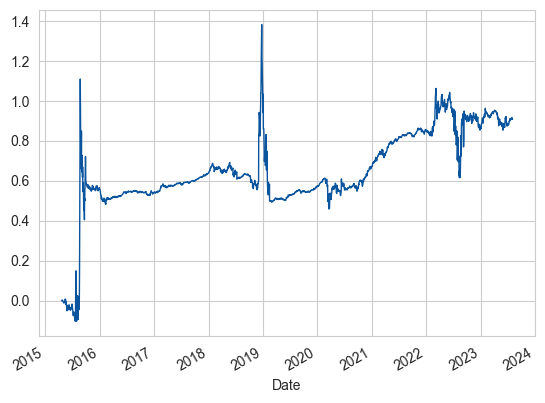

In [52]:
mv_w_ = mv_w.loc[returns[len(returns)//2:].index].shift()
mv_r = (mv_w_ * returns[len(returns)//2:]).sum(axis=1)
mv_r.cumsum().plot();

In [33]:
# Aggregating the features (prices and returns).

features = pd.concat([prices.loc[returns.index], returns], axis=1)
features.head()

,AGG,DBC,VTI,^VIX,AGG,DBC,VTI,^VIX
Date,,,,,,,,
2007-01-04,100.120003,23.180000,70.114998,11.51,0.002100,-0.026396,0.001999,-0.045018
2007-01-05,100.050003,23.100000,69.559998,12.14,-0.000699,-0.003457,-0.007947,0.053290
2007-01-08,100.110001,23.219999,69.815002,12.00,0.000599,0.005181,0.003659,-0.011599
2007-01-09,100.110001,23.020000,69.815002,11.91,0.000000,-0.008651,0.000000,-0.007528
2007-01-10,100.000000,22.680000,69.970001,11.47,-0.001099,-0.014880,0.002218,-0.037643


In [34]:
# Defining dimensions for input and target.

data  = features.copy()
seq_len = 50

n_assets = len(returns.columns)
n_samples = len(data[seq_len:])
n_features = len(data.columns)

print(f'''- Number of Assets: {n_assets}
- Length of Data: {len(data)}
- Length: {seq_len}
- Number of Samples: {n_samples} ({len(data)} - {seq_len}) 
- Number of features: {n_features} ({n_assets} assets x {n_features//n_assets} features)''')

- Number of Assets: 4
- Length of Data: 4175
- Length: 50
- Number of Samples: 4125 (4175 - 50) 
- Number of features: 8 (4 assets x 2 features)


In [35]:
# Creating input array (3D).

input = np.zeros((n_samples, seq_len, n_features))
target = returns.iloc[seq_len:].values[:n_samples]

for i in range(n_samples):
    input[i] = features.iloc[i:(i + seq_len)].values

print(f'''- Input shape: {input.shape}
- Target shape: {target.shape}''')

- Input shape: (4125, 50, 8)
- Target shape: (4125, 4)


                                                    +--------------------+
                                                    |       Input        |
                                                    +--------------------+
                                                              |
                                                              v
                                                    +--------------------+
                                                    |       LSTM         | -> (last output, hidden_dim)
                                                    +--------------------+
                                                              |
                                                              v
                                                    +--------------------+
                                                    |      Linear        | -> (output_dim)
                                                    +--------------------+
                                                              |
                                                              v
                                                    +--------------------+
                                                    |      Softmax       | -> (output_dim)
                                                    +--------------------+
                                                              |
                                                              v
                                                    +--------------------+
                                                    |      Output        | -> (output_dim)
                                                    +--------------------+

In [36]:
# Defining the model architecture.

class PortOptNN(Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PortOptNN, self).__init__()
        self.lstm = LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = Linear(hidden_dim, output_dim, bias=True)
        self.softmax = Softmax(dim=-1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out_last = lstm_out[:, -1, :]
        fc_out = self.fc(lstm_out_last)
        output = self.softmax(fc_out)
        return output
    
 def objective(outputs, targets):
    portfolio_returns = (outputs * targets).sum(dim=1)
    mean_portfolio_return = portfolio_returns.mean()
    mean_squared_portfolio_return = (portfolio_returns ** 2).mean()
    denominator = torch.sqrt(mean_squared_portfolio_return - mean_portfolio_return ** 2)
    custom_objective_value = mean_portfolio_return / denominator
    return custom_objective_value

In [37]:
# Defining Model Parameters

input_dim = input.shape[-1]
hidden_dim = 64
output_dim = target.shape[-1]

In [54]:
epochs = 100
gains = []

model = PortOptNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), maximize=True)

train_input = input[:len(input)//2]; train_input_torch = torch.tensor(train_input, dtype=torch.float32)
train_target = target[:len(input)//2]; train_target_torch = torch.tensor(train_target, dtype=torch.float32)
test_input = input[len(input)//2:len(input)]; test_input_torch = torch.tensor(test_input, dtype=torch.float32)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_input_torch)
    gain = objective(outputs, train_target_torch)
    gain.backward()
    gains.append(gain.item())
    optimizer.step()
    print(f'{epoch + 1}/{epochs}: Gain: {gain.item()}', end='\r')

with torch.no_grad():
    test_outputs = model(test_input_torch)

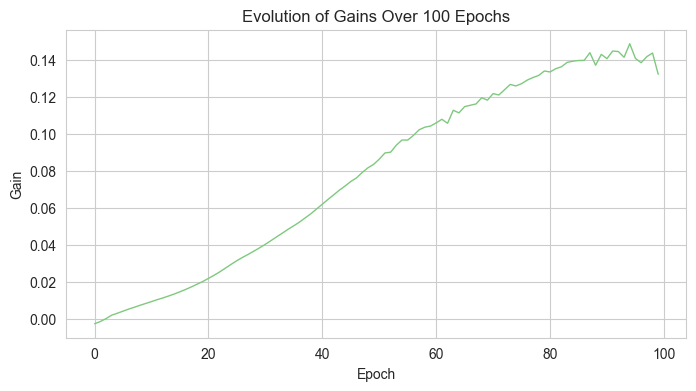

In [47]:
plt.figure(figsize=(8, 4))
sns.lineplot(gains)
plt.title('Evolution of Gains Over 100 Epochs')
plt.ylabel('Gain')
plt.xlabel('Epoch')
plt.show()

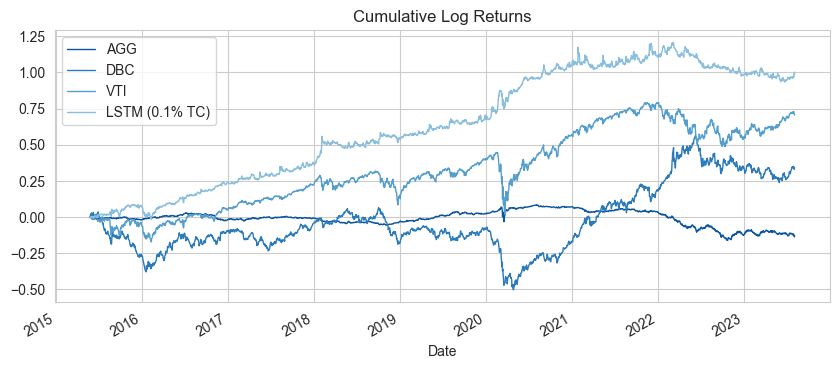

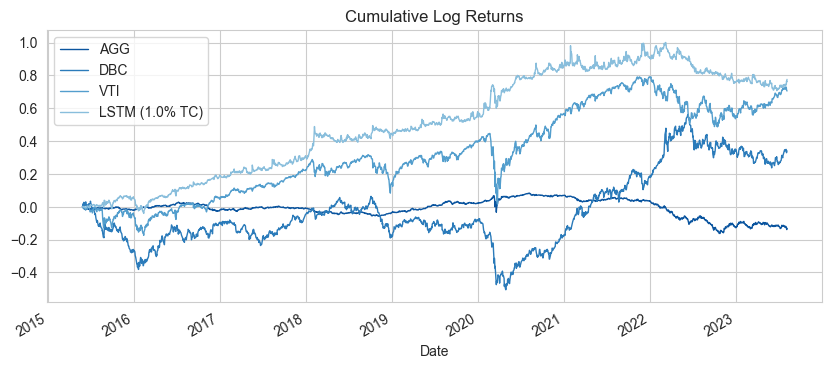

In [53]:
weights = pd.DataFrame(
    test_outputs, 
    index=returns.index[-len(test_outputs):],
    columns=returns.columns
).shift()

backtest_returns = returns.loc[weights.index].copy()
backtest_returns.loc[backtest_returns.index.min()] = {stock: 0 for stock in indices}
model_returns = weights.multiply(backtest_returns).sum(axis=1)

def plot_with_tc(cost, model_returns, backtest_returns):
    transaction_costs_series = cost * (weights.diff().abs().sum(axis=1))
    model_returns_ = model_returns.copy()
    backtest_returns_ = backtest_returns.copy()
    model_returns_ -= transaction_costs_series

    backtest_returns_[f'LSTM ({cost*100}% TC)'] = model_returns_
    backtest_cumulative_returns = backtest_returns_.drop(columns='^VIX').cumsum()
    backtest_cumulative_returns.plot(figsize=(10, 4))
    plt.title('Cumulative Log Returns');

    return backtest_returns_

tc_001 = plot_with_tc(.001, model_returns, backtest_returns)
tc_01 = plot_with_tc(.01, model_returns, backtest_returns)

In [42]:
for ret in [tc_001, tc_01]:
    metrics = Metrics({col: ret[col] for col in ret.drop(columns='^VIX')})
    metrics = metrics.calculate()
    display(metrics.sort_values(by=['Cumulative Return', 'Sharpe Ratio'], ascending=False))

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
LSTM (0.1% TC),1.001778,0.122369,0.159293,0.642649,-0.274246
VTI,0.704880,0.086103,0.190475,0.347042,-0.430787
DBC,0.340160,0.041551,0.184910,0.116550,-0.568555
AGG,-0.130618,-0.015955,0.052660,-0.682784,-0.245053


,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
LSTM (1.0% TC),0.775372,0.094713,0.159585,0.468172,-0.293258
VTI,0.704880,0.086103,0.190475,0.347042,-0.430787
DBC,0.340160,0.041551,0.184910,0.116550,-0.568555
AGG,-0.130618,-0.015955,0.052660,-0.682784,-0.245053


In [43]:
import matplotlib.pyplot as plt

start_ = '2023-01'
end_ = '2023-08'

